In [7]:
import numpy as np
from pylab import figure, plot, xlabel, ylabel, title
from numpy import math,  cos, sin, pi,fft,arange,transpose,sqrt
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [20]:
fs = 3.05e3  # Switching frequency is 3 kHz
Ts = 1/(fs) #1 / (2 * fs) #half period
mm = np.linspace(0.0, 0.99, 101)  # mi as a array 0 - 1
mi = (sqrt(3)*mm)/2 #Normalised with max 0.5m
m=0.8
angle = math.pi / 5 #15 deg


# Find the index corresponding to mi = 0.8
mi_target = 0.7

In [21]:
# Level 3 PWM Modulation Index
def findvrvl(mi, angle):
    vr = mi * (cos(angle)-(sin(angle)/sqrt(3)))
    vl = 2 * mi * (sin(angle)/sqrt(3))
    return vr, vl

def findvavb(mi, angle):
    va = mi * cos(angle)
    vb = mi * sin(angle)
    return va, vb

def kint(va, vb):
    k1 = int(va*2 + (vb*2 / sqrt(3)))
    k2 = int(vb*2 / (sin(pi/3)))
    vai = va*2 - k1 + 0.5*k2
    vbi = vb*2 - k2*((sqrt(3))/2)
    
    if k1 == 0 and k2 == 0:
        # Triangle 1
        region = 1
    elif k1 == 1 and k2 == 1:
        # Triangle 4
        region = 4
    elif k1 == 1 and k2 == 0:
        if vbi <= (vai * sqrt(3)):
            # Triangle 2
            region = 2
        elif vbi > (vai * sqrt(3)):
            # Triangle 3
            region = 3
    else:
        region = 0
    return region

def caseDutyCc2(m1, m2, region):
    d0, d1, d2 = 0, 0, 0

    if region == 2:
        d1 = m1 - 0.5
        d2 = m2
        d0 = 1 - m1 - m2
    elif region == 3:
        d2 = 0.5 - m2
        d1 = 0.5 - m1
        d0 = m1 + m2 - 0.5
    elif region == 4:
        d1 = m1
        d2 = m2 - 0.5
        d0 = 1 - m1 - m2
    elif region == 1:
        d1 = m1
        d2 = m2
        d0 = 0.5 - m1 - m2
    else:
        pass

    return d0, d1, d2


def angle_between_vectors(m1, m2, theta):
    # Calculate the magnitude of the resultant vector using the law of cosines
    m3 = np.sqrt(m1**2 + m2**2 - 2 * m1 * m2 * np.cos(theta))

    # Calculate the angle
    gamma = ((m2*sin(theta))/(m1+(m2*cos(theta))))
    
    # Return the angle in radians
    return np.arctan(gamma), m3


def spacevectortimes(vref, sectorangle, subcycleperiod):
    t2 = vref * subcycleperiod * (np.sin(sectorangle) / np.sin(np.pi / 3))
    t1 = vref * subcycleperiod * (np.sin(np.pi / 3 - sectorangle) / np.sin(np.pi / 3))
    t0 = subcycleperiod - t2 - t1
    return t2, t1, t0


def fluxripplevector(sectorangle, t_2, t_1, tz, mi):
    qz = -(mi) * tz
    q1 = (cos(sectorangle)-mi)*t_1
    q2 = (cos((math.pi/3)-(sectorangle))-mi)*t_2
    d = sin(sectorangle)*t_1
    return qz, q1, q2, d

def phi(qz, q2, q1, d, t2, t1, tz, subcycleperiod):
    phisq012 = ((1/3)*(qz**2)*(tz/subcycleperiod))+((1/3)*((qz**2)+(qz*(qz+q1))+((qz+q1)**2))*(t1/subcycleperiod))+((1/3)*((qz+q1)**2)*(t2/subcycleperiod))+((1/3)*(d**2)*((t1+t2)/subcycleperiod))
    phisq721 = ((1/3)*(qz**2)*(tz/subcycleperiod))+((1/3)*((qz**2)+(qz*(qz+q2))+((qz+q2)**2))*(t2/subcycleperiod))+((1/3)*((qz+q2)**2)*(t1/subcycleperiod))+((1/3)*(d**2)*((t1+t2)/subcycleperiod))
    Rphisq012 = sqrt(phisq012)*100
    Rphisq721 = sqrt(phisq721)*100
    return Rphisq012, Rphisq721

# def calculate_phi(qz, q2, q1, d, t2, t1, tz, subcycleperiod, ang_n):
#     err = 0
    
#     if 0 <= ang_n <= math.pi/6:
#         err = ((1/3)*(qz**2)*(tz/subcycleperiod))+((1/3)*((qz**2)+(qz*(qz+q1))+((qz+q1)**2))*(t1/subcycleperiod))+((1/3)*((qz+q1)**2)*(t2/subcycleperiod))+((1/3)*(d**2)*((t1+t2)/subcycleperiod))
    
#     elif math.pi/6 < ang_n <= math.pi/3:
#         err = ((1/3)*(qz**2)*(tz/subcycleperiod))+((1/3)*((qz**2)+(qz*(qz+q2))+((qz+q2)**2))*(t2/subcycleperiod))+((1/3)*((qz+q2)**2)*(t1/subcycleperiod))+((1/3)*(d**2)*((t1+t2)/subcycleperiod))

#     return err

def calculate_phi012(qz, q2, q1, d, t2, t1, tz, subcycleperiod):
    err = ((1/3)*(qz**2)*(tz/subcycleperiod))+((1/3)*((qz**2)+(qz*(qz+q1))+((qz+q1)**2))*(t1/subcycleperiod))+((1/3)*((qz+q1)**2)*(t2/subcycleperiod))+((1/3)*(d**2)*((t1+t2)/subcycleperiod))
    return err

def calculate_phi721(qz, q2, q1, d, t2, t1, tz, subcycleperiod):        
    err = ((1/3)*(qz**2)*(tz/subcycleperiod))+((1/3)*((qz**2)+(qz*(qz+q2))+((qz+q2)**2))*(t2/subcycleperiod))+((1/3)*((qz+q2)**2)*(t1/subcycleperiod))+((1/3)*(d**2)*((t1+t2)/subcycleperiod))
    return err

def calculate_phi(qz, q2, q1, d, t2, t1, tz, subcycleperiod, ang_n):
    if 0 <= ang_n <= math.pi/6:
        return calculate_phi012(qz, q2, q1, d, t2, t1, tz, subcycleperiod)
    elif math.pi/6 < ang_n <= math.pi/3:
        return calculate_phi721(qz, q2, q1, d, t2, t1, tz, subcycleperiod)
    else:
        return 0  # Handle other cases as needed


def find_intersection(mi_values, y_values, mi_target):
    y_target = np.interp(mi_target, mi_values, y_values)
    return y_target

In [22]:
va, vb = findvavb(m, angle)
region = kint(va, vb)
#d200, d210, d100_211, d110_221, d220, d111 =caseDutyCc(va, vb, region)
print (va)
print (vb)
print (angle*180/pi)
# print (k1)
# print(k2)
print (region)
#rint (vbi)
vr, vl = findvrvl(m, angle)
d0, d1, d2 =caseDutyCc2(vr, vl, region)
print (d1)
print (d2)
# print (d210)
# print (d100_211)
# #print (d110_221)
#print (d111)
ang_n, mag_m =angle_between_vectors(d1, d2, pi/3)
print (ang_n*180/pi)
print (mag_m)

0.647213595499958
0.4702282018339785
36.0
4
0.3757272165905568
0.04297275781880239
5.3524970419819
0.3561903487139452


C:\Users\chengxu\AppData\Local\Temp/ipykernel_28320/593389551.py:65: RuntimeWarning: invalid value encountered in double_scalars
  gamma = ((m2*sin(theta))/(m1+(m2*cos(theta))))


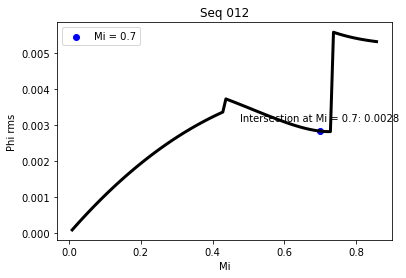

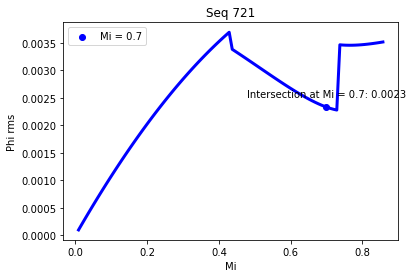

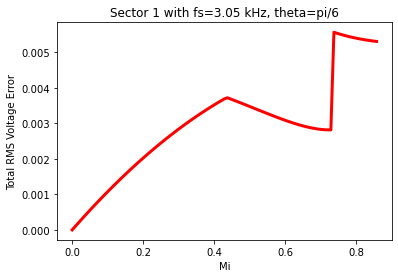

In [23]:
def main():
    phi012_rms = []
    phi721_rms = []
    phi_rms =[]
    for m in mi:
       
        va, vb = findvavb(m, angle)
        vr, vl = findvrvl(m, angle)
        region = kint(va, vb)
        d0, d1, d2 =caseDutyCc2(vr, vl, region)
       
        ang_n, mag_m =angle_between_vectors(d1, d2, pi/3)
        
        
        #Apply to level 2
        t_2, t_1, tz = spacevectortimes(mag_m, ang_n, Ts)
        qz, q1, q2, d = fluxripplevector(ang_n, t_2, t_1, tz, mag_m)
        Rphisq012, Rphisq721 = phi(qz, q1, q2, d, t_2, t_1, tz, Ts)
        phi_n = calculate_phi(qz, q1, q2, d, t_2, t_1, tz, Ts, ang_n)
        Rphisq = sqrt(phi_n)*100
    
        phi_rms.append(Rphisq)
    
        phi012_rms.append(Rphisq012)
        phi721_rms.append(Rphisq721)
 
         # Append values based on sector angle range
#         if 0 <= ang_n <= math.pi/6:
#             #phi_rms.append(Rphisq012)
#             phi_rms = phi012_rms
#         elif math.pi/6 < ang_n <= math.pi/3:
#             #phi_rms.append(Rphisq721)
#             phi_rms = phi721_rms
           
    intersection_y = find_intersection(mi, phi721_rms, mi_target)
    intersection_y2 = find_intersection(mi, phi012_rms, mi_target)
        

  
    
    plt.figure(2)
    plt.plot(mi, phi012_rms, lw=3, color='black')
    plt.xlabel("Mi")
    plt.ylabel("Phi rms")
    plt.title("Seq 012")

   
    plt.scatter(mi_target, intersection_y2, c='blue', label=f'Mi = {mi_target}')
    plt.annotate(f'Intersection at Mi = {mi_target}: {intersection_y2:.4f}', (mi_target, intersection_y2), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.legend()


    plt.figure(3)
    plt.plot(mi, phi721_rms, lw=3, color='blue')
    plt.xlabel("Mi")
    plt.ylabel("Phi rms")
    plt.title("Seq 721")

   
    plt.scatter(mi_target, intersection_y, c='blue', label=f'Mi = {mi_target}')
    plt.annotate(f'Intersection at Mi = {mi_target}: {intersection_y:.4f}', (mi_target, intersection_y), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.legend()
    
    
    plt.figure(1)
    plt.plot(mi, phi_rms, lw=3, color='red')
    plt.xlabel("Mi")
    plt.ylabel("Total RMS Voltage Error")
    plt.title("Sector 1 with fs=3.05 kHz, theta=pi/6")


    
    
    plt.show()

  
       

if __name__ == "__main__":
    main()

In [6]:
# def caseDutyCc(m1, m2, region):
#     d200, d210, d100_211, d110_221, d220, d111 = 0, 0, 0, 0, 0, 0

#     if region == 2:
#         d200 = m1 - 0.5
#         d210 = m2
#         d100_211 = 1 - m1 - m2
#     elif region == 3:
#         d100_211 = 0.5 - m2
#         d110_221 = 0.5 - m1
#         d210 = m1 + m2 - 0.5
#     elif region == 4:
#         d210 = m1
#         d220 = m2 - 0.5
#         d110_221 = 1 - m1 - m2
#     elif region == 1:
#         d100_211 = m1
#         d110_221 = m2
#         d111 = 0.5 - m1 - m2
#     else:
#         # Handle other cases or provide an error message
#         pass

#     return d200, d210, d100_211, d110_221, d220, d111
